<a href="https://colab.research.google.com/github/gregory-237/ApplicationProgrammingLab5_PyTorch/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime
from typing import Tuple, Any

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

from google.colab import files


uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [39]:
df = pd.read_csv('/content/dataset.csv', sep=',', names=['Date', 'Value']).query('Date >= "1998-01-01"').query('Date <= "2022-01-01"')
df

,Date,Value
426,2021-12-31,74.2926
427,2021-12-30,73.6514
428,2021-12-29,73.4959
429,2021-12-28,73.2329
430,2021-12-25,73.1886
...,...,...
6381,1998-01-10,5.9740
6382,1998-01-09,5.9720
6383,1998-01-07,5.9690
6384,1998-01-06,5.9630


In [40]:
df = df.set_index(['Date'])
df = df.rename(columns={'Exchange':'Value'})
df

,Value
Date,
2021-12-31,74.2926
2021-12-30,73.6514
2021-12-29,73.4959
2021-12-28,73.2329
2021-12-25,73.1886
...,...
1998-01-10,5.9740
1998-01-09,5.9720
1998-01-07,5.9690


In [41]:
count = df.count().Value
count

5960

In [42]:
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
  df = df.sort_index()
df

<ipython-input-42-415838e27613>:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not df.index.is_monotonic:


,Value
Date,
1998-01-01,5.9600
1998-01-06,5.9630
1998-01-07,5.9690
1998-01-09,5.9720
1998-01-10,5.9740
...,...
2021-12-25,73.1886
2021-12-28,73.2329
2021-12-29,73.4959


In [44]:
def generate_features(df, n_features):
    df_n = df.copy()
    for n in range(1, n_features + 1):
        df_n[f"f{n}"] = df_n["Value"].shift(n)
    df_n = df_n.iloc[n_features:]
    return df_n

input_dim = 12

df_features = generate_features(df, input_dim)
df_features

,Value,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
Date,,,,,,,,,,,,,
1998-01-22,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630,5.9600
1998-01-23,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630
1998-01-24,6.0200,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690
1998-01-27,6.0200,6.0200,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720
1998-01-28,6.0210,6.0200,6.0200,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,73.1886,73.3583,73.7901,73.8206,74.2947,73.7330,73.5708,73.8510,73.4698,73.4107,73.6059,73.5998,73.8453
2021-12-28,73.2329,73.1886,73.3583,73.7901,73.8206,74.2947,73.7330,73.5708,73.8510,73.4698,73.4107,73.6059,73.5998
2021-12-29,73.4959,73.2329,73.1886,73.3583,73.7901,73.8206,74.2947,73.7330,73.5708,73.8510,73.4698,73.4107,73.6059


In [45]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    x = df.drop(columns=[target_col])
    return x, y

def train_test_valid_split(df, target_col, test_ratio):
    valid_ratio = test_ratio / (1 - test_ratio)
    x, y = feature_label_split(df, target_col)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, shuffle=False)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio, shuffle=False)
    return x_train, x_test, x_valid, y_train, y_test, y_valid

x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(df_features, 'Value', 0.1)

In [46]:
len(x_train), len(x_test), len(x_valid)

(4758, 595, 595)

In [47]:
x_train

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
Date,,,,,,,,,,,,
1998-01-22,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630,5.9600
1998-01-23,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630
1998-01-24,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690
1998-01-27,6.0200,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720
1998-01-28,6.0200,6.0200,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-02,57.9627,57.9371,57.4762,57.8590,58.0967,57.6342,57.1507,56.7719,57.7388,58.0619,58.8457,59.0235
2017-03-03,58.3776,57.9627,57.9371,57.4762,57.8590,58.0967,57.6342,57.1507,56.7719,57.7388,58.0619,58.8457
2017-03-04,58.4067,58.3776,57.9627,57.9371,57.4762,57.8590,58.0967,57.6342,57.1507,56.7719,57.7388,58.0619


In [48]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('minmax')
x_train_arr = scaler.fit_transform(x_train)
x_test_arr = scaler.transform(x_test)
x_valid_arr = scaler.transform(x_valid)

y_train_arr = scaler.fit_transform(y_train)
y_test_arr = scaler.transform(y_test)
y_valid_arr = scaler.transform(y_valid)

In [49]:
batch_size = 128

train_features = torch.Tensor(x_train_arr)
train_targets = torch.Tensor(y_train_arr)
test_features = torch.Tensor(x_test_arr)
test_targets = torch.Tensor(y_test_arr)
valid_features = torch.Tensor(x_valid_arr)
valid_targets = torch.Tensor(y_valid_arr)

train = TensorDataset(train_features, train_targets)
test = TensorDataset(test_features, test_targets)
valid = TensorDataset(valid_features, valid_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [50]:
class SimpleModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(SimpleModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [51]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_Exchanges'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 20) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(model.state_dict(), os.path.join("/content", "weight.pt"))

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/150] Training loss: 0.0106	 Validation loss: 0.0581
[2/150] Training loss: 0.0318	 Validation loss: 0.0663
[3/150] Training loss: 0.0294	 Validation loss: 0.0113
[4/150] Training loss: 0.0097	 Validation loss: 0.0039
[5/150] Training loss: 0.0052	 Validation loss: 0.0185
[6/150] Training loss: 0.0074	 Validation loss: 0.0212
[7/150] Training loss: 0.0096	 Validation loss: 0.0170
[8/150] Training loss: 0.0105	 Validation loss: 0.0138
[9/150] Training loss: 0.0101	 Validation loss: 0.0275
[10/150] Training loss: 0.0069	 Validation loss: 0.0058
[11/150] Training loss: 0.0054	 Validation loss: 0.0186
[12/150] Training loss: 0.0135	 Validation loss: 0.0666
[13/150] Training loss: 0.0097	 Validation loss: 0.0464
[14/150] Training loss: 0.0093	 Validation loss: 0.0021
[15/150] Training loss: 0.0017	 Validation loss: 0.0040
[16/150] Training loss: 0.0032	 Validation loss: 0.0104
[17/150] Training loss: 0.0103	 Validation loss: 0.0031
[18/150] Training loss: 0.0179	 Validation loss: 0.0083
[

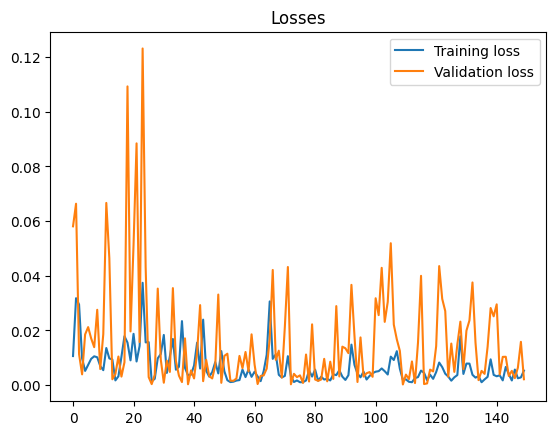

In [52]:
input_dim = len(x_train.columns)
output_dim = 1
hidden_dim = 32
layer_dim = 2
batch_size = 128
dropout = 0.2
n_epochs = 150
learning_rate = 10e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = SimpleModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

,Value,Prediction
Date,,
2019-08-07,65.203003,65.689568
2019-08-08,65.093201,65.750282
2019-08-09,65.129906,65.812279
2019-08-10,65.254303,65.857773
2019-08-13,65.428703,65.903923
...,...,...
2021-12-25,73.188599,67.177742
2021-12-28,73.232903,67.172722
2021-12-29,73.495903,67.167244


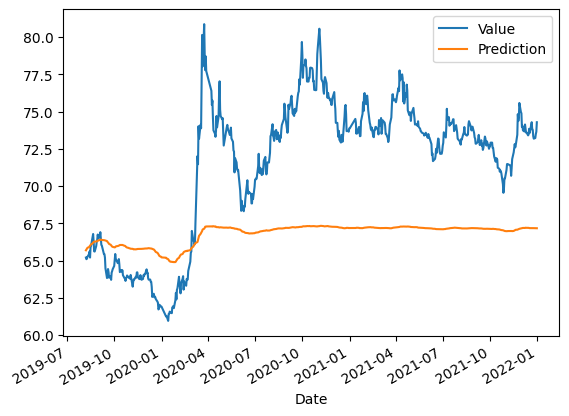

In [53]:
def inverse_transform(scaler, df, columns):
  """Reversing columns"""
  for col in columns:
    df[col] = scaler.inverse_transform(df[col])
  return df

def format_predictions(predictions, values, df_test, scaler):
  """Formating predictions because it scaled"""
  vals = np.concatenate(values, axis=0).ravel()
  preds = np.concatenate(predictions, axis=0).ravel()
  df_result = pd.DataFrame(data={"Value": vals, "Prediction": preds}, index=df_test.head(len(vals)).index)
  df_result = df_result.sort_index()
  df_result = inverse_transform(scaler, df_result, [["Value", "Prediction"]])
  return df_result

df_result = format_predictions(predictions, values, x_test, scaler)
df_result.plot()
df_result

In [54]:
def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.Value, df.Prediction),
                      'rmse' : mean_squared_error(df.Value, df.Prediction) ** 0.5,
                      'r2' : r2_score(df.Value, df.Prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        5.5231714
Root Mean Squared Error:    6.212677564328487
R^2 Score:                  -0.7652000307405782


In [55]:
model = SimpleModel(**model_params)
model.load_state_dict(torch.load(os.path.join("/content", "weight.pt")))
model.to(device)

SimpleModel(
  (rnn): RNN(12, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

,Value,Prediction
Date,,
2019-08-07,65.203003,65.689568
2019-08-08,65.093201,65.750282
2019-08-09,65.129906,65.812279
2019-08-10,65.254303,65.857773
2019-08-13,65.428703,65.903923
...,...,...
2021-12-25,73.188599,67.177742
2021-12-28,73.232903,67.172722
2021-12-29,73.495903,67.167244


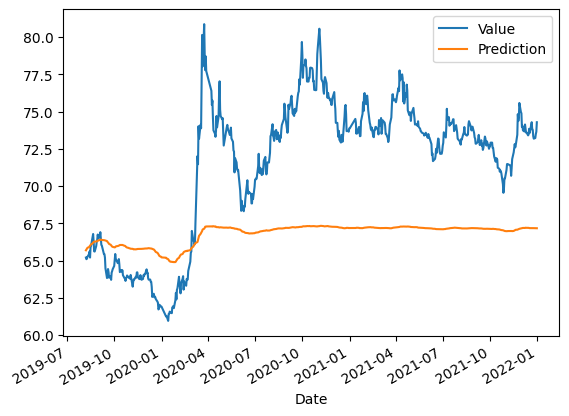

In [58]:
test_loader_two = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

predictions, values = opt.evaluate(
    test_loader_two,
    batch_size=1,
    n_features=input_dim
)

df_result = format_predictions(predictions, values, x_test, scaler)
df_result.plot()
df_result